In [1]:
%load_ext autoreload
%autoreload 2

import os
from jax import config
config.update("jax_enable_x64", True)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

import tensorflow_datasets as tfds  # TFDS for MNIST
import tensorflow as tf             # TensorFlow operations

# from image_distribution_models import PixelCNN

from cleanplots import *
import jax.numpy as np
from jax.scipy.special import logsumexp
import numpy as onp
from encoding_information.image_utils import *
from encoding_information.bsccm_utils import *
from encoding_information.image_utils import *

2023-11-25 21:30:28.253157: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 21:30:28.791043: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cublas/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_cupti/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_nvcc/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_nvrtc/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_runtime/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/pyth

In [48]:


bsccm = BSCCM('/home/hpinkard_waller/data/BSCCMNIST/')
cell_images = load_bsccm_images(bsccm, channel='LED119', num_images=10000).astype(np.float32)

Opening BSCCMNIST
Opened BSCCMNIST


In [49]:
(mnist, mnist_labels), (_ , _) = tf.keras.datasets.mnist.load_data()
mnist = (mnist.astype(np.float32) / 255.) * 300 + 25 
mnsit = mnist[:cell_images.shape[0]]


# rescale cell_images to the same range as mnist
(cell_images - cell_images.mean()) / cell_images.std() * mnist.std() + mnist.mean()


# concatenate mnist and cell images and create binary labels 
images = np.concatenate([cell_images, mnist])
labels = np.concatenate([np.ones(len(cell_images)), np.zeros(len(mnist))])
# convert to one-hot
labels = np.eye(2)[labels.astype(np.int32)]

# shuffle
idx = onp.arange(len(images))
onp.random.shuffle(idx)
images = images[idx]
labels = labels[idx]


# plot some images with their lebels as titles
fig, ax = plt.subplots(2, 5, figsize=(10, 4))


In [2]:
# #MNIST
# (patches, labels), (_ , _) = tf.keras.datasets.mnist.load_data()
# patches = (patches.astype(np.float32) / 255.) * 300 + 25 

# # patches = add_noise(patches)

# # convert labels to one-hot encoding
# labels = tf.one_hot(labels, 10).numpy()
# labels  


2023-11-25 21:30:34.622920: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [51]:
from encoding_information.models.pixel_cnn import PixelCNN

pixel_cnn = PixelCNN()
pixel_cnn.fit(images, max_epochs=5, num_val_samples=100, condition_vectors=labels)



Initial validation NLL: 9.67


Epoch 1: 100%|██████████| 100/100 [00:07<00:00, 12.97it/s]


Epoch 1: validation NLL: 2.12


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 32.39it/s]


Epoch 2: validation NLL: 1.90


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 31.94it/s]


Epoch 3: validation NLL: 1.83


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 31.99it/s]


Epoch 4: validation NLL: 3.74


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 32.31it/s]


Epoch 5: validation NLL: 1.84


[9.674720764160156,
 2.1182289123535156,
 1.8953875303268433,
 1.833936095237732,
 3.741502046585083,
 1.837880253791809]

In [52]:
num_samples = 10

# create 5 samples conditioned on one hot for class 0
conditioning_vecs = onp.zeros((num_samples, 2))
conditioning_vecs[0:num_samples//2, 0] = 1
conditioning_vecs[num_samples//2:, 1] = 1


samples = pixel_cnn.generate_samples(num_samples=num_samples, conditioning_vecs=conditioning_vecs)

Generating PixelCNN samples: 100%|██████████| 28/28 [07:35<00:00, 16.27s/it]


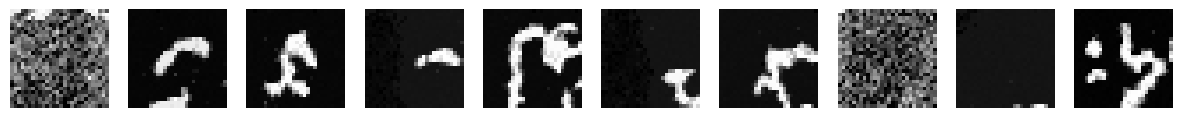

In [53]:
# plot samples
fig, axs = plt.subplots(1, num_samples, figsize=(15, 15))
for i in range(num_samples):
    axs[i].imshow(samples[i], cmap='gray')
    axs[i].axis('off')